# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. Вывод являяется обязательным!

In [ ]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl ./

Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


In [ ]:
train_path = "./train.jsonl"
dev_path = "./dev.jsonl"

In [ ]:
!pip install transformers

In [ ]:
import random
import torch
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import transformers as ppb

import re

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, random_split, Subset, DataLoader, Sampler

import torch.optim as optim

import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

import gc

import json
import os
import nltk
import torch

from torchtext.legacy import data
from torchtext.legacy import datasets
from torchtext.vocab import GloVe


from nltk.tokenize.stanford import StanfordTokenizer

import torch.nn as nn
import torch.nn.functional as F


from dataclasses import dataclass, field

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# зафиксируем рандомы для воспроизводимости результатов

random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

In [ ]:
train_data_df = pd.read_json("train.jsonl", lines=True, orient='records')
dev_data_df = pd.read_json("dev.jsonl", lines=True, orient="records")

passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

In [ ]:
questions_dev[-5:]

array(['is manic depression the same as bi polar',
       'was whiskey galore based on a true story',
       'are there plants on the international space station',
       'does the hockey puck have to cross the line to be a goal',
       'will there be a season 5 of shadowhunters'], dtype=object)

Для проверки моделей приготовим тестовыe примеры.

In [ ]:
test_passages = passages_dev[-5:]
test_questions = questions_dev[-5:]
test_answers = answers_dev[-5:]

### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

# Соображения по методологии

# Проведение одного эксперимента
1. Подбирайте гиперпараметры! Это довольно важно. Гиперпараметры --- это размеры слоёв, например. Хотя бы в одном эксперименте это стоит сделать честно, в остальных экспериментах в принципе можно предполагать, что в предыдущем эксперименте оптимальные размеры модели уже найдены.
2. Часто вам придётся скачивать предобученные веса (вроде BERT или RoBERTa) и дообучать дополнительные веса. В таком случае стоит попробовать несколько разных подходов:
* обучать только новые (головные) слои 
* обучать совместно всю модель
* сначала обучить головные слои, потом дофайнтьюнить веса всей модели
3. Фиксируйте лучшие результаты на валидационной выборке, по валидационной же выборке останавливайте обучение
4. Графики, графики, графики
5. Делайте промежуточные выводы

# Общие соображения
1. Один эксперимент --- одно изменение! Вы не представляете, насколько это важно. Пример: для эксперимента с моделью 1 Петя для получения эмбеддингов скачал предобученные веса BERT, а для эксперимента с моделью 2 -- предобученные веса RoBERTa. Вторая модель оказалась лучше, и Петя подумал, что архитектура второй модели лучше. Но, оказывается, с весами RoBERTa модель 1 работала бы не менее хорошо. 
2. Всегда сравнивайте результаты эксперимента с результатами всех остальных экспериментов и делайте промежуточные выводы. ***Это самый важный пункт!***
3. Не забывайте протестировать модель на адекватность. Для этого нужно задавать ей реальные вопросы и смотреть на ответы. Вопросы не должны быть элементами обучающей выборки!


## Часть 1. Эксплоративный анализ (1 балл)
1. Посчитайте долю yes и no классов в корпусе
2. Оцените среднюю длину вопроса
3. Оцените среднюю длину параграфа
4. Предположите, по каким эвристикам были собраны вопросы (или найдите ответ в статье). Продемонстриуйте, как эти эвристики повлияли на структуру корпуса. 

In [ ]:
passages_corpus = np.hstack([passages_train, passages_dev])
questions_corpus = np.hstack([questions_train, questions_dev])
answers_corpus = np.hstack([answers_train, answers_dev])

In [ ]:
noyes = np.bincount(answers_corpus)
print("NO - ", noyes[0]/noyes.sum(), ", YES - ", noyes[1]/noyes.sum()  )

NO -  0.3772544695597385 , YES -  0.6227455304402615


In [ ]:
lens_question = np.array([len(x.split()) for x in questions_corpus])
print('mean length of question ', lens_question.mean())

mean length of question  8.787745136646452


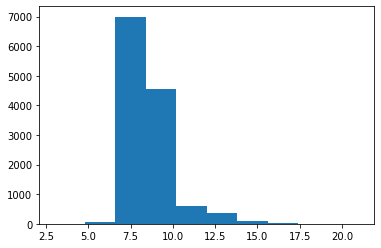

In [ ]:
plt.hist(lens_question)
plt.show()

In [ ]:
lens_passages= np.array([len(x.split()) for x in passages_corpus])
print('mean length of passage ', lens_passages.mean())

mean length of passage  92.90989997637237


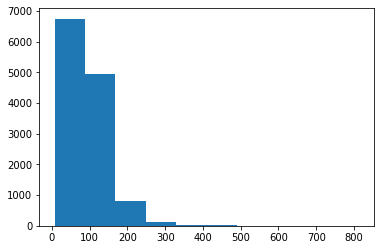

In [ ]:
plt.hist(lens_passages)
plt.show()

Вопросы для датасета BoolQ собирались из массива анонимизированных аггрегированных запросов к поисковику Google. Отбирались вопросы достаточной длины, начинающиеся с эвристически отобранных слов (“did”, “do”, “does”, “is”, “are”, “was”, “were”, “have”, “has”, “can”, “could”, “will”, “would”) и содержащие в топ-5 поисковой выдачи ссылку на Википедию. В результате, как показано выше, сами вопросы имеют длину в среднем 9 слов.

In [ ]:
question_words = []
for question in questions_corpus:
  question_words.extend(question.split())
print('Total words in question corpus ', len(question_words))

Total words in question corpus  111578


In [ ]:
df_question = pd.DataFrame(question_words)
qvc = df_question.value_counts()

In [ ]:
qvc[['no', 'not', 'don\'t']]

no       52
not      50
don't    13
dtype: int64

Видно, что отрицание редко встречается в вопросах. Авторы статьи отмечают, что в вопросах датасета редко встречаются вопросы о фактах, касающихся простых свойств сущностей. Например, можно показать, что конкретные численные значения редки.

In [ ]:
regex_num = re.compile('\d+')  
numbers = regex_num.findall(' '.join(question_words))
len(numbers) 

1842

## Часть 2. Baseline (1 балл)
1. Оцените accuracy точность совсем простого базового решения: присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части
2. Оцените accuracy чуть более сложного базового решения: fasttext на текстах, состоящих из склееных вопросов и абзацев (' '.join([question, passage]))

Почему fasttext плохо справляется с этой задачей?

**Константное решение**

In [ ]:
const_pred = np.bincount(answers_train).argmax()
const_pred = np.ones_like(answers_dev) * const_pred
print('Accuracy score for constant model: ', accuracy_score(answers_dev, const_pred))

Accuracy score for constant model:  0.6217125382262997


**Fasttext**

In [ ]:
!pip3 install fasttext

In [ ]:
import fasttext
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer
import re
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

%matplotlib inline

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Уберем пунктуацию и спецсимволы
        document = re.sub(r'\W', ' ', str(document))
        # Заменим множественные пробелы на один
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Преобразуем в нижнгий регистр
        document = document.lower()
        # Уберем стоп-слова, короткие слова и лемматизируем
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 2]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [ ]:
# Подготовим данные
passages_val, passages_test, questions_val, questions_test, answers_val, answers_test = \
  train_test_split(passages_dev, questions_dev, answers_dev, test_size=0.5)

In [ ]:
def data_prepare (passages, questions, answers, mode = 'train'):
  snts = []
  trgs = []
  for i in range(len(passages)):
    snt = preprocess_text(' '.join([questions[i], passages[i]]))
    trg = '__label__' + str(answers[i])
    snts.append(snt)
    trgs.append(trg)
  df = pd.DataFrame({'txt': snts, 'target': trgs})
  df[['target', 'txt']].to_csv(mode + '_data.txt', header=False, index=False, sep="\t")

In [ ]:
data_prepare (passages_train, questions_train, answers_train, mode = 'train')
data_prepare (passages_val, questions_val, answers_val, mode = 'val')

In [ ]:
model = fasttext.train_supervised('train_data.txt', autotuneValidationFile='val_data.txt', autotuneMetric="f1:__label__1")

Progress: 100.0% Trials:   23 Best score:  0.777778 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  37305
Number of labels: 2
Progress: 100.0% words/sec/thread: 1261874 lr:  0.000000 avg.loss:  0.625655 ETA:   0h 0m 0s


In [ ]:
ft_pred = []
for i in range(len(passages_test)):
  snt = preprocess_text(' '.join([questions_test[i], passages_test[i]]))
  p = model.predict(snt, k=2)
  label = 0
  ft_pred.append(model.predict(snt, k=2)[1][0] > 0.5)

In [ ]:
print('Accuracy score for FastTEXT model: ', accuracy_score(answers_test, ft_pred))

Accuracy score for FastTEXT model:  0.6281345565749236


FastTEXT плохо справляется с задачей, поскольку не учитывает позиции токенов. Эта модель больше подходит для тематической классификации текстов.

## Часть 3. Используем эмбеддинги предложений (2 балла)
1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

[bonus] Используйте другие модели эмбеддингов, доступные, например, в библиотеке 🤗 Transformers. Какая модель эмбеддингов даст лучшие результаты?

[bonus] Предложите метод аугментации данных и продемонстрируйте его эффективность. 

Загрузим предобученный БЕРТ с токенайзером.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Подготовим класс для работы с данными.

In [ ]:
class QADataset(Dataset):
    def __init__(self, passages, questions, answers, tokenizer):
        self.labels = answers
        # tokenization
        self.passages = passages.apply((lambda x: x if (len(x) <= 512) else x[:512]))
        self.passages = self.passages.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
        self.questions = questions.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
        
    def __getitem__(self, idx):
        return {"passages": self.passages[idx], "questions": self.questions[idx], "labels": self.labels[idx]}

    def __len__(self):
        return len(self.labels)


Загрузим данные в датасеты, разобъем dev на валидационную и тестовую части.

In [ ]:
train_data = QADataset(train_data_df['passage'], train_data_df['question'], train_data_df['answer'],  tokenizer)
dev_data = QADataset(dev_data_df['passage'], dev_data_df['question'], dev_data_df['answer'],  tokenizer)

train_data = Subset(train_data, range(len(train_data)))
val_size = int(.5 * len(dev_data)) 
valid_data, test_data = random_split(dev_data, [val_size, len(dev_data) - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 9427
Number of validation examples: 1635
Number of testing examples: 1635


Подготовим итераторы.

In [ ]:
class QASampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset
        
        self.indices = subset.indices

        self.passages = np.array(subset.dataset.passages)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.passages))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [ ]:
def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    passages = []
    questions = []
    labels = []
    for elem in batch:
        passages.append(elem['passages'])
        questions.append(elem['questions'])
        labels.append(elem['labels'])

    questions = get_padded(questions)
    attention_mask_q = np.where(questions != 0, 1, 0)

    passages = get_padded(passages)
    attention_mask_p = np.where(passages != 0, 1, 0)

    return {'passages': torch.tensor(passages), 'questions': torch.tensor(questions), 
            'labels': torch.FloatTensor(labels), 
            'attention_mask_p' : torch.tensor(attention_mask_p), 'attention_mask_q' : torch.tensor(attention_mask_q)}

In [ ]:
train_loader = DataLoader(train_data, batch_sampler=QASampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=QASampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=QASampler(test_data), collate_fn=collate_fn)

Подготовим функцию, выдающую на основе итератора признаки (эмбеддинги предобученных трансформеров) и метки для последующей передачи в логистическую регрессию.

In [ ]:
def get_xy(loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            
            questions = batch['questions'].to(device)
            passages = batch['passages'].to(device)
            attention_mask_p = batch['attention_mask_p'].to(device)
            attention_mask_q = batch['attention_mask_q'].to(device)
            label = batch['labels']

            last_hidden_states_p = model(passages, attention_mask=attention_mask_p)
            last_hidden_states_q = model(questions, attention_mask=attention_mask_q)
            
            features.append(torch.cat([last_hidden_states_q[0][:, 0, :], last_hidden_states_p[0][:, 0, :]], dim=1).cpu())
            labels.append(label.cpu())

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    return features, labels

In [ ]:
train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Обучим и проверим логистическую регрессию. Гиперпараметры логрега подбирались на этапе экспериментов с использованием GridSearchCV.

In [ ]:
clf = LogisticRegression(C=0.005, penalty='l2', solver='saga')
clf.fit(train_features, train_labels)
clf.score(test_features, test_labels)

0.655045871559633

Результат - 0.6550.

Попробуем большую модель Берт

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)
model.eval()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

Заново подготовим данные (с учетом возможного отличия токенайзера).

In [ ]:
train_data = QADataset(train_data_df['passage'], train_data_df['question'], train_data_df['answer'],  tokenizer)
dev_data = QADataset(dev_data_df['passage'], dev_data_df['question'], dev_data_df['answer'],  tokenizer)

train_data = Subset(train_data, range(len(train_data)))
val_size = int(.5 * len(dev_data)) 
valid_data, test_data = random_split(dev_data, [val_size, len(dev_data) - val_size])

train_loader = DataLoader(train_data, batch_sampler=QASampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=QASampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=QASampler(test_data), collate_fn=collate_fn)

train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
clf = LogisticRegression(C=0.05, penalty='l2', solver='liblinear')
clf.fit(train_features, train_labels)
clf.score(test_features, test_labels)

0.6770642201834862

Результат - 0.6771

Возьмём roBRETa

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel,ppb.RobertaTokenizer, 'roberta-large')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)
model.eval()

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 1024, padding_idx=1)
    (position_embeddings): Embedding(514, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (d

In [ ]:
train_data = QADataset(train_data_df['passage'], train_data_df['question'], train_data_df['answer'],  tokenizer)
dev_data = QADataset(dev_data_df['passage'], dev_data_df['question'], dev_data_df['answer'],  tokenizer)

train_data = Subset(train_data, range(len(train_data)))
val_size = int(.5 * len(dev_data)) 
valid_data, test_data = random_split(dev_data, [val_size, len(dev_data) - val_size])

train_loader = DataLoader(train_data, batch_sampler=QASampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=QASampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=QASampler(test_data), collate_fn=collate_fn)

train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
clf = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
clf.fit(train_features, train_labels)
clf.score(test_features, test_labels)

0.6568807339449542

Результат - 0.6569

Пробуем также ELECTRA.

In [ ]:
# 'google/electra-small-discriminator'
model_class, tokenizer_class, pretrained_weights = (ppb.ElectraModel,ppb.ElectraTokenizer, 'google/electra-large-generator')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)
model.eval()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/663 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/196M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-large-generator were not used when initializing ElectraModel: ['generator_lm_head.weight', 'generator_lm_head.bias', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embeddings_project): Linear(in_features=1024, out_features=256, bias=True)
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256

In [ ]:
train_data = QADataset(train_data_df['passage'], train_data_df['question'], train_data_df['answer'],  tokenizer)
dev_data = QADataset(dev_data_df['passage'], dev_data_df['question'], dev_data_df['answer'],  tokenizer)

train_data = Subset(train_data, range(len(train_data)))
val_size = int(.5 * len(dev_data)) 
valid_data, test_data = random_split(dev_data, [val_size, len(dev_data) - val_size])

train_loader = DataLoader(train_data, batch_sampler=QASampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=QASampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=QASampler(test_data), collate_fn=collate_fn)

train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
clf = LogisticRegression(C=15, penalty='l2', solver='liblinear')
clf.fit(train_features, train_labels)
clf.score(test_features, test_labels)

0.6495412844036698

Результат - 0.6495

И ещё ALBERT.

In [ ]:
# 'albert-base-v2'
model_class, tokenizer_class, pretrained_weights = (ppb.AlbertModel,ppb.AlbertTokenizer, 'albert-xxlarge-v2')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)
model.eval()

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-xxlarge-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(30000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=4096, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((4096,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=4096, out_features=4096, bias=True)
              (key): Linear(in_features=4096, out_features=4096, bias=True)
              (value): Linear(in_features=4096, out_features=4096, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False

In [ ]:
train_data = QADataset(train_data_df['passage'], train_data_df['question'], train_data_df['answer'],  tokenizer)
dev_data = QADataset(dev_data_df['passage'], dev_data_df['question'], dev_data_df['answer'],  tokenizer)

train_data = Subset(train_data, range(len(train_data)))
val_size = int(.5 * len(dev_data)) 
valid_data, test_data = random_split(dev_data, [val_size, len(dev_data) - val_size])

train_loader = DataLoader(train_data, batch_sampler=QASampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=QASampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=QASampler(test_data), collate_fn=collate_fn)

train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
clf = LogisticRegression(C=0.07, penalty='l2', solver='liblinear')
clf.fit(train_features, train_labels)
clf.score(test_features, test_labels)

0.6629969418960244

Результат - 0.6630

Лучший результат (accuracy=0.6771) показало использование эмбеддингов BERT_Large. Он выше бейзлайна, но не сильно. Проверим модель на подготовленном примере.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model = model.to(device)
model.eval()

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
train_data = QADataset(train_data_df['passage'], train_data_df['question'], train_data_df['answer'],  tokenizer)
dev_data = QADataset(dev_data_df['passage'], dev_data_df['question'], dev_data_df['answer'],  tokenizer)

train_data = Subset(train_data, range(len(train_data)))
val_size = int(.5 * len(dev_data)) 
valid_data, test_data = random_split(dev_data, [val_size, len(dev_data) - val_size])

train_loader = DataLoader(train_data, batch_sampler=QASampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=QASampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=QASampler(test_data), collate_fn=collate_fn)

train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
clf = LogisticRegression(C=0.05, penalty='l2', solver='liblinear')
clf.fit(train_features, train_labels)
clf.score(test_features, test_labels)

0.6678899082568808

Посмотрим ещё f1-метрику.

In [ ]:
preds = clf.predict(test_features)
print('F1-score: ', f1_score(test_labels, preds))

F1-score:  0.7574810183117464


In [ ]:
def predict (model, tokenizer, clf, questions, passages):
  
    for i in range(len(questions)):
        question = tokenizer.encode(questions[i], add_special_tokens=True)
        question = torch.LongTensor(question).unsqueeze(0).to(device)
        attention_mask_q = torch.ones_like(question).to(device)

        passage = tokenizer.encode(passages[i], add_special_tokens=True)
        passage = torch.LongTensor(passage).unsqueeze(0).to(device)
        attention_mask_p = torch.ones_like(passage).to(device)

        last_hidden_states_p = model(passage, attention_mask=attention_mask_p)
        last_hidden_states_q = model(question, attention_mask=attention_mask_q)

        features = torch.cat([last_hidden_states_q[0][:, 0, :], last_hidden_states_p[0][:, 0, :]], dim=1).cpu().detach().numpy()

        pred = clf.predict(features)



        print("Q.: ", questions[i])
        # print("P.: ", passages[i])
        if pred:
            print ('YES')
        else:
            print('NO')

In [ ]:
predict (model, tokenizer, clf, test_questions, test_passages)

Q.:  is manic depression the same as bi polar
YES
Q.:  was whiskey galore based on a true story
NO
Q.:  are there plants on the international space station
YES
Q.:  does the hockey puck have to cross the line to be a goal
NO
Q.:  will there be a season 5 of shadowhunters
NO


Плоховатые ответы.

Продолжим эксперименты в следующем ноутбуке.